In [104]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [105]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [106]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [107]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [123]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [124]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [125]:
#Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [126]:
# Table information for column names
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [127]:
# Review measurement data for format reference
engine.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [128]:
# Review station data for format reference
engine.execute(text('SELECT * FROM station LIMIT 5')).fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [129]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [115]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
recent_date

('2017-08-23',)

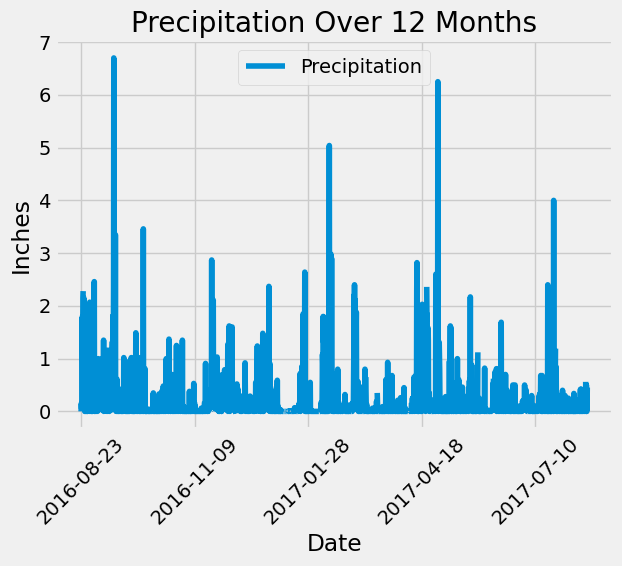

In [116]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_yr = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_year_df = pd.DataFrame(rain_year)
rain_year_df = rain_year_df.rename(columns={"id": "ID", "station": "Station", "date": "Date", "prcp": "Precipitation", "tobs": "Temperature"})
rain_year_df = rain_year_df.set_index('Date')


# Sort the dataframe by date - Note: already sorted above with order by function


# Use Pandas Plotting with Matplotlib to plot the data
rain_year_df.plot()
plt.title("Precipitation Over 12 Months")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel("Inches")
plt.savefig("./Images/prcpovertime.png")
plt.show()

In [117]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [118]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
station_count

9

In [119]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station,func.count(Measurement.station)).order_by(func.count(Measurement.station).desc()).group_by(Measurement.station).all() 
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [120]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_summary = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station=='USC00519281').all()
temp_summary

[(54.0, 85.0, 71.66378066378067)]

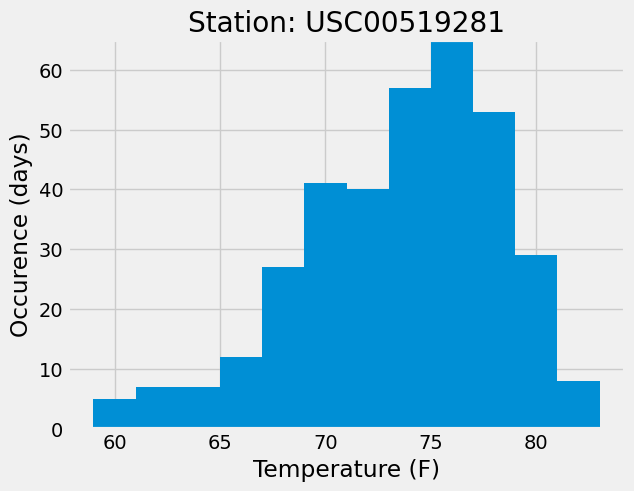

In [121]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date >= '2016-08-23').all()
year_tobs_df = pd.DataFrame(year_tobs)['tobs']
hist = year_tobs_df.hist(bins=12)
plt.title('Station: USC00519281')
plt.xlabel('Temperature (F)')
plt.ylabel('Occurence (days)')
plt.ylim(0,65)
plt.savefig("./Images/activestation.png")


# Close Session

In [122]:
# Close Session
session.close()